<a href="https://colab.research.google.com/github/tharungajula2/Portfolio/blob/main/Project202_%E2%8F%B3AR(p).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the case where the autocorrelation coefficients
slowly decay or exhibit a sinusoidal pattern, then you are possibly in the presence of
an autoregressive process.

Summary
1. An autoregressive process states that the present value is linearly dependent on
its past values and an error term.
2. If the ACF plot of a stationary process shows a slow decay, then you likely have
an autoregressive process.
3. The partial autocorrelation measures the correlation between two lagged values of a time series when you remove the effect of the other autocorrelated
lagged values.
4. Plotting the PACF of a stationary autoregressive process will show the order p of
the process. The coefficients will be significant up until lag p only.

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/foot_traffic.csv')

In [28]:
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


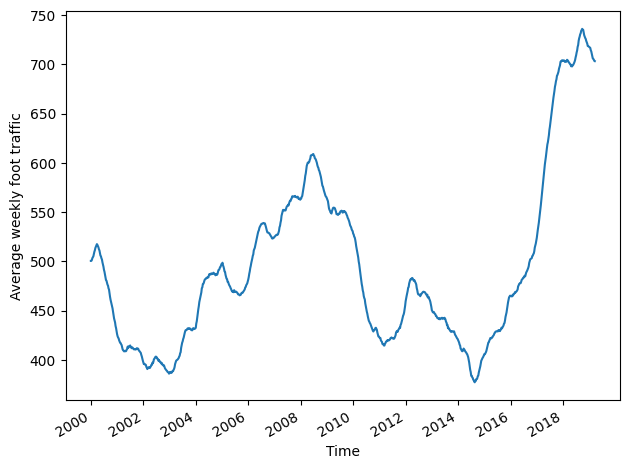

In [29]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

* we can see a long-term trend with peaks and troughs along the way. We
can intuitively say that this time series is not a stationary process, since we observe a
trend over time.
* Furthermore, there is no apparent cyclical pattern in the data, so we
can rule out any seasonal effects for now.

* so we will have to apply a transformation in order to make it stationary. Then we will plot the ACF.
* As we work, we will see that
not only is there autocorrelation, but the ACF plot will have a slowly decaying trend.
* This is indicative of an autoregressive process of order p, also denoted as AR(p). In
this case, we must plot the partial autocorrelation function (PACF) to find the order p.
* Just like the coefficients on an ACF plot for an MA(q) process, the coefficients on the
PACF plot will become abruptly non-significant after lag p, hence determining the
order of the autoregressive process.
* Again, the order of the autoregressive process determines how many parameters
must be included in the AR(p) model. Then we will be ready to make forecasts. In this
example, we wish to forecast next week’s average foot traffic.

## yt = C + φ1yt –1 + φ2yt–2 +⋅⋅⋅ φpyt–p + ϵt

If we have a first-order
autoregressive process, also denoted as AR(1), then the present value yt is only dependent on a constant C, the value at the previous timestep φ1yt –1, and some white noise 'ϵt', and if φ1 = 1, it becomes our Random Walk Model

In [30]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df['foot_traffic'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


In [31]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

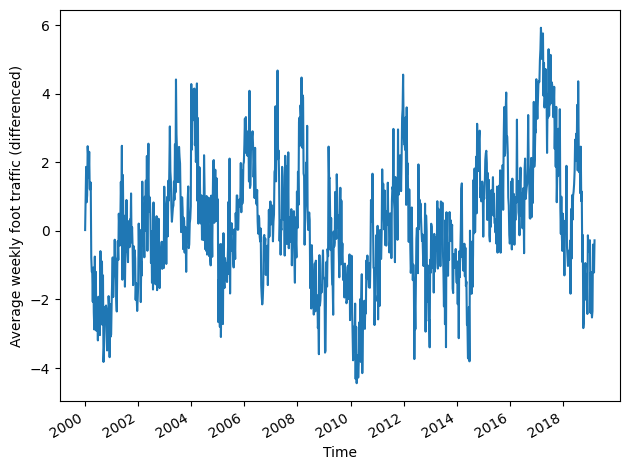

In [32]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

The next step is to plot the ACF and see if there is autocorrelation and if the coefficients become abruptly non-significant after a certain lag.

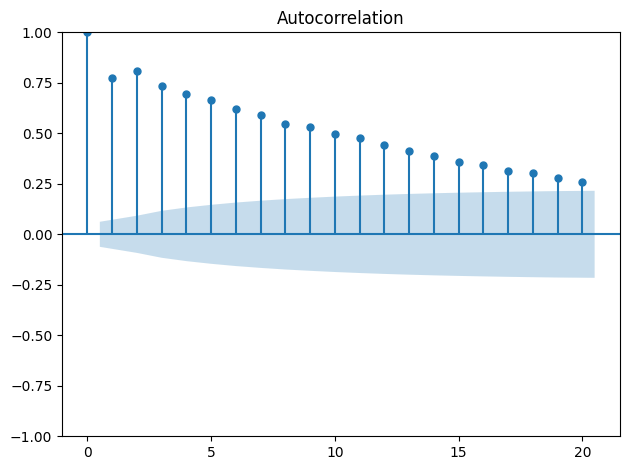

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(foot_traffic_diff, lags=20);
plt.tight_layout()

 * Notice that we have significant autocorrelation coefficients beyond lag 0. Therefore, we know that our process is not a random walk. Furthermore, you’ll notice that the coefficients are decaying exponentially as the lag increases.
  
 * Therefore, there is no lag at which the coefficients abruptly become nonsignificant. This means that we do not have a moving average process and that we are
likely studying an autoregressive process.

* When the ACF plot of a stationary process exhibits a pattern of exponential decay,
we probably have an autoregressive process in play, and we must find another way to
identify the order p of the AR(p) process. Specifically, we must turn our attention to
the partial autocorrelation function (PACF) plot.

In [34]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
np.random.seed(42)
ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])
AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

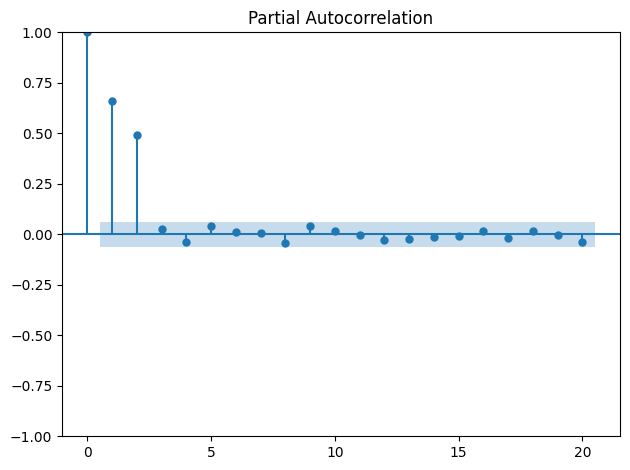

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(AR2_process, lags=20);
plt.tight_layout()

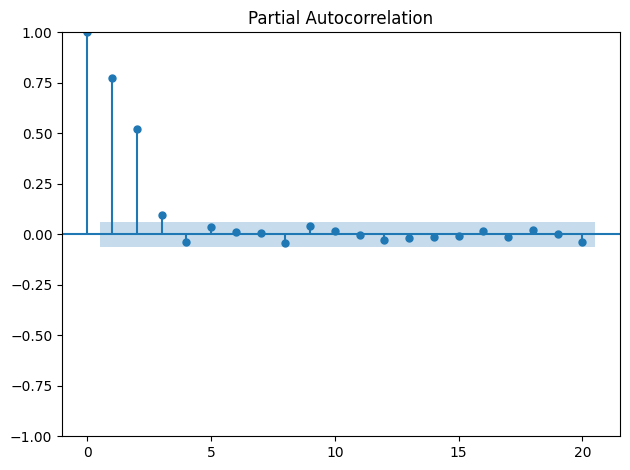

In [36]:
plot_pacf(foot_traffic_diff, lags=20);
plt.tight_layout()

In [37]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
train = df_diff[:-52]
test = df_diff[-52:]
print(len(train))
print(len(test))

947
52


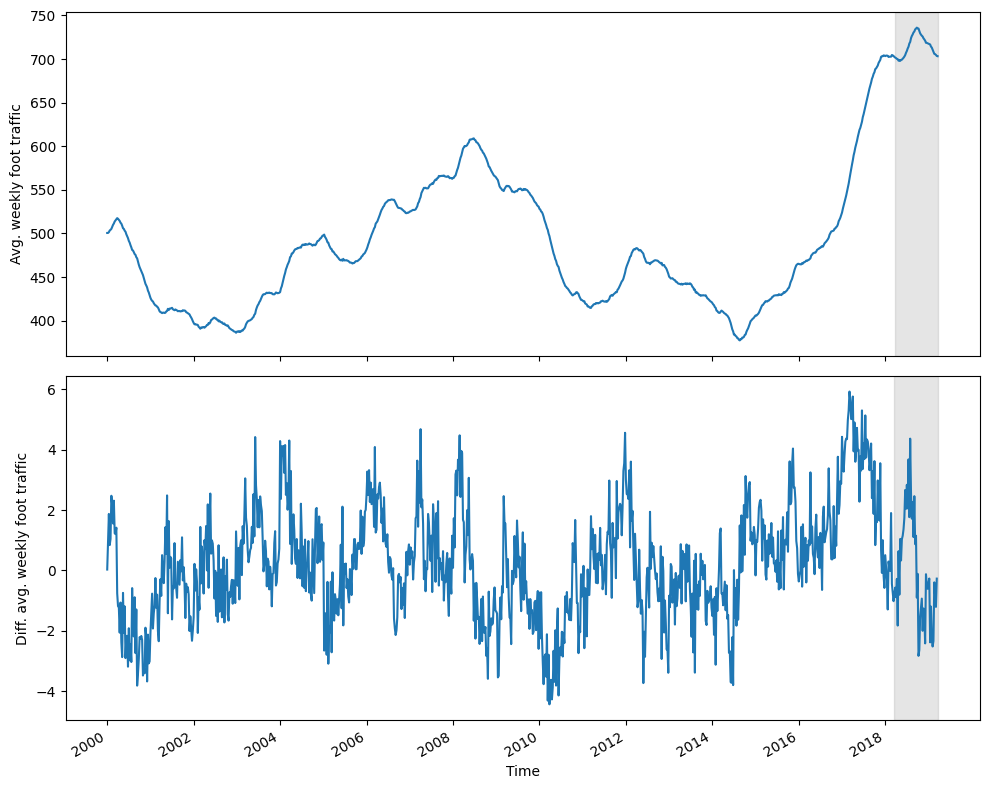

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True,
figsize=(10, 8))
ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)
ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()

We will again use the SARIMAX function from statsmodels, as it encompasses an AR
model. As mentioned previously, SARIMAX is a complex model that allows us to consider seasonal effects, autoregressive processes, non-stationary time series, moving
average processes, and exogenous variables all in one single model. For now, we will
disregard all factors except the moving autoregressive portion.

In [39]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [40]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


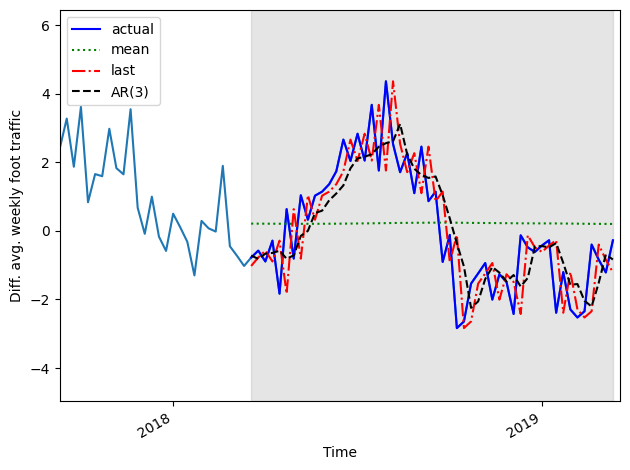

In [41]:
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

We can now visualize our predictions against the observed values in the test set. Note
that we are working with the differenced series, so our predictions are also differenced values.

In [42]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164116852


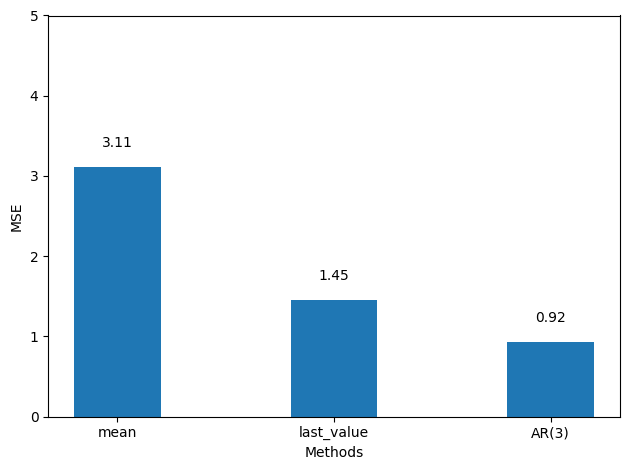

In [43]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

This prints out an MSE of 3.11 for the historical mean method, 1.45 for the last known
value method, and 0.92 for the AR(3) model. Since the MSE for the AR(3) model is
the lowest of the three, we conclude that the AR(3) model is the best-performing
method for forecasting next week’s average foot traffic.

Since our forecasts are differenced values, we need to reverse the transformation
in order to bring our forecasts back to the original scale of the data; otherwise, our predictions will not make sense in a business context. To do this, we can take the cumulative sum of our predictions and add it to the last value of our training set in the
original series. This point occurs at index 948, since we are forecasting the last 52
weeks in a dataset containing 1,000 points.

In [44]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

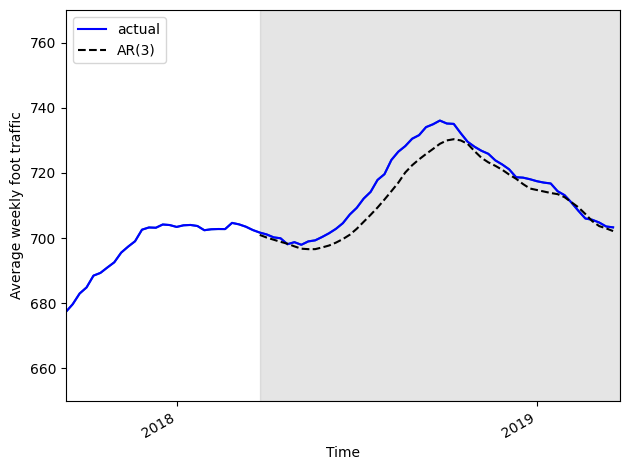

In [45]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [46]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

3.478033559658852


This prints out a mean absolute error of 3.45. This means that our predictions are off
by 3.45 people on average, either above or below the actual value for the week’s foot
traffic.